# Pre-requisites

Installing Gym Sokoban environment as Linux package.

In [2]:
!pip install gym-sokoban

Instaling required modules in Google Colab as Linux packages.

In [3]:
!apt-get install -y xvfb python-opengl x11-utils

!pip install pyvirtualdisplay PyOpenGL PyOpenGL-accelerate kora

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  libgle3 mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 python-opengl x11-utils xvfb
0 upgraded, 4 newly installed, 0 to remove and 15 not upgraded.
Need to get 1,490 kB of archives.
After this operation, 8,397 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.8 [784 kB]
Fetched 1,490 kB in 0s (6,158 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 146456 files and di

Importing basic set of libraries.

In [4]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import pyvirtualdisplay

import gym_sokoban

Import seaborn to make charts better.

In [5]:
import seaborn as sns

sns.set()

# Reusable assets

Defining an abstract class for A2C agent and concrete implementation of it. Also defining a class to store expirience for A2C updates.

In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class OnPolicy(nn.Module):
    def __init__(self):
        super(OnPolicy, self).__init__()
        
    def forward(self, x):
        raise NotImplementedError
        
    def act(self, x, deterministic=False):       
        logit, value = self.forward(x)                       
        probs = F.softmax(logit, dim=1)       
        
        if deterministic:
            action = probs.max(1)[1]
        else:
            action = probs.multinomial(num_samples=1)
        
        return action
    
    def evaluate_actions(self, x, action):
        logit, value = self.forward(x)
        
        probs     = F.softmax(logit, dim=1)
        log_probs = F.log_softmax(logit, dim=1)
        
        action_log_probs = log_probs.gather(1, action)       

        entropy = -(probs * log_probs).sum(1).mean()
        
        return logit, action_log_probs, value, entropy
    

class ActorCritic(OnPolicy):
    def __init__(self, in_shape, num_actions):
        super(ActorCritic, self).__init__()
        
        self.in_shape = in_shape
        self.in_channels = in_shape[0]
        self.out_channels = 16

        self.features = nn.Sequential(
            nn.Conv2d(self.in_channels, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            # nn.AvgPool2d(2, stride=2),
            # nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, stride=1),
            # nn.ReLU(),
            # nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, stride=2),
            # nn.ReLU(),
        )
        
        fc_size = 512
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), fc_size),
            nn.ReLU(),
        )
                
        self.critic  = nn.Linear(fc_size, 1)
        self.actor   = nn.Linear(fc_size, num_actions)
        
    def forward(self, x):          
        x = self.features(x)
        # x = x.view(x.size(0),-1)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        logit = self.actor(x)
        value = self.critic(x)
        return logit, value

    def feature_size(self):  
        # convoutput1 = self.calculate_conv_output((int(self.in_shape[1]/2), int(self.in_shape[2]/2)), self.out_channels, 3)
        convoutput1 = self.calculate_conv_output(self.in_shape[1:3], 32, 8, 4)       
        convoutput2 = self.calculate_conv_output(convoutput1[1:3], 64, 4, 2)
        convoutput3 = self.calculate_conv_output(convoutput2[1:3], 64, 3, 1)
        features = int(np.prod(convoutput3))
        return features

    def calculate_conv_output(self, img_dim, out_channels, kernel_size, stride=1, padding=0):   
        # print(img_dim, out_channels, kernel_size)     
        output_width = (img_dim[0] - kernel_size + 2*padding) // stride + 1
        output_height = (img_dim[1] - kernel_size + 2*padding) // stride + 1
        # print(out_channels, output_width, output_height)
        return [out_channels, output_width, output_height]

    
class RolloutStorage(object):
    def __init__(self, num_steps, num_envs, state_shape):
        self.num_steps = num_steps
        self.num_envs  = num_envs
        self.states  = torch.zeros(num_steps + 1, num_envs, *state_shape)
        self.rewards = torch.zeros(num_steps,     num_envs, 1)
        self.masks   = torch.ones(num_steps  + 1, num_envs, 1)
        self.actions = torch.zeros(num_steps,     num_envs, 1).long()
        self.use_cuda = False
            
    def cuda(self):
        self.use_cuda  = True
        self.states    = self.states.cuda()
        self.rewards   = self.rewards.cuda()
        self.masks     = self.masks.cuda()
        self.actions   = self.actions.cuda()
        
    def insert(self, step, state, action, reward, mask):
        self.states[step + 1].copy_(state)
        self.actions[step].copy_(action)
        self.rewards[step].copy_(reward)
        self.masks[step + 1].copy_(mask)
        
    def after_update(self):
        self.states[0].copy_(self.states[-1])
        self.masks[0].copy_(self.masks[-1])
        
    def compute_returns(self, next_value, gamma):
        returns   = torch.zeros(self.num_steps + 1, self.num_envs, 1)
        if self.use_cuda:
            returns = returns.cuda()
        returns[-1] = next_value
        for step in reversed(range(self.num_steps)):
            returns[step] = returns[step + 1] * gamma * self.masks[step + 1] + self.rewards[step]
        return returns[:-1]

Defining class for logger to store training statistics.

In [ ]:
import io
import pickle
import os
import torch

class Logger():
    
    def log(self, data, directoryPath="", filename="dummy"):
        if not os.path.exists(directoryPath):
            os.makedirs(directoryPath)
        
        if not directoryPath.endswith("/"):
            directoryPath += "/"
        directoryPath += filename
        self.dump(data=data, filename=directoryPath)
        print("{0} saved".format(filename))

    def log_state_dict(self, state_dict, path, name=""):
        torch.save(state_dict, path)
        print("Model {0} saved".format(name))

    def dump(self, data, filename):
        with open(filename, "wb") as f:
            pickle.dump(data, f)

    def load(self, filename):
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        return data

    def loadwithoutfirstelem(self, filename):
        data = self.load(filename)
        del data[0]
        return data

    def printDayFormat(self, message, seconds):
        days, hours, minutes, seconds = self.convertSeconds(seconds)
        print(message, '{0:02}:{1:02}:{2:02}:{3:02}'.format(int(days), int(hours), int(minutes), int(seconds)))

    def convertSeconds(self, seconds):
        days = seconds // 86400
        seconds -= (days * 86400)
        hours = seconds//3600
        seconds -= hours * 3600
        minutes = seconds//60
        seconds -= minutes * 60
        return days, hours, minutes, seconds

Defining class for timer which will be used to estimate time required for training.

In [ ]:
import time

class myTimer():

    def __init__(self):
        self.reset()
    
    def reset(self):
        self.timediff = 0
        self.total_time = 0
        self.last_time = 0
        self.online_mean = 0
        self.online_count = 0

    def update(self, current_time):
        self.timediff = current_time - self.last_time
        if self.last_time > 0:           
            self.total_time += self.timediff
            self.updateAvg()

        self.last_time = current_time

    def getTimeDiff(self):
        return self.timediff

    def getAvgTimeDiff(self):
        return self.online_mean
    
    def updateAvg(self):
        self.online_count += 1
        self.online_mean += (self.timediff - self.online_mean) / self.online_count           

    def getTotalTime(self):
        return self.total_time

    def getTimeToGo(self, loopsToGo):
        return loopsToGo * self.online_mean

Defining a class which will be used to execute multiple environments in parallel.

In [ ]:
import numpy as np
from multiprocessing import Process, Pipe

def worker(remote, parent_remote, env_fn_wrapper):
    parent_remote.close()
    env = env_fn_wrapper.x()
    while True:
        cmd, data = remote.recv()
        if cmd == 'step':
            ob, reward, done, info = env.step(data)
            if done:
                ob = env.reset()
            remote.send((ob, reward, done, info))
        elif cmd == 'reset':
            ob = env.reset()
            remote.send(ob)
        elif cmd == 'reset_task':
            ob = env.reset_task()
            remote.send(ob)
        elif cmd == 'close':
            remote.close()
            break
        elif cmd == 'get_spaces':
            remote.send((env.observation_space, env.action_space))
        else:
            raise NotImplementedError

class VecEnv(object):
    """
    An abstract asynchronous, vectorized environment.
    """
    def __init__(self, num_envs, observation_space, action_space):
        self.num_envs = num_envs
        self.observation_space = observation_space
        self.action_space = action_space

    def reset(self):
        """
        Reset all the environments and return an array of
        observations, or a tuple of observation arrays.
        If step_async is still doing work, that work will
        be cancelled and step_wait() should not be called
        until step_async() is invoked again.
        """
        pass

    def step_async(self, actions):
        """
        Tell all the environments to start taking a step
        with the given actions.
        Call step_wait() to get the results of the step.
        You should not call this if a step_async run is
        already pending.
        """
        pass

    def step_wait(self):
        """
        Wait for the step taken with step_async().
        Returns (obs, rews, dones, infos):
         - obs: an array of observations, or a tuple of
                arrays of observations.
         - rews: an array of rewards
         - dones: an array of "episode done" booleans
         - infos: a sequence of info objects
        """
        pass

    def close(self):
        """
        Clean up the environments' resources.
        """
        pass

    def step(self, actions):
        self.step_async(actions)
        return self.step_wait()

    
class CloudpickleWrapper(object):
    """
    Uses cloudpickle to serialize contents (otherwise multiprocessing tries to use pickle)
    """
    def __init__(self, x):
        self.x = x
    def __getstate__(self):
        import cloudpickle
        return cloudpickle.dumps(self.x)
    def __setstate__(self, ob):
        import pickle
        self.x = pickle.loads(ob)

class SubprocVecEnv(VecEnv):
    def __init__(self, env_fns, spaces=None):
        """
        envs: list of gym environments to run in subprocesses
        """
        self.waiting = False
        self.closed = False
        nenvs = len(env_fns)
        self.nenvs = nenvs
        self.remotes, self.work_remotes = zip(*[Pipe() for _ in range(nenvs)])
        self.ps = [Process(target=worker, args=(work_remote, remote, CloudpickleWrapper(env_fn)))
            for (work_remote, remote, env_fn) in zip(self.work_remotes, self.remotes, env_fns)]
        for p in self.ps:
            p.daemon = True # if the main process crashes, we should not cause things to hang
            p.start()
        for remote in self.work_remotes:
            remote.close()

        self.remotes[0].send(('get_spaces', None))
        observation_space, action_space = self.remotes[0].recv()
        VecEnv.__init__(self, len(env_fns), observation_space, action_space)

    def step_async(self, actions):
        for remote, action in zip(self.remotes, actions):
            remote.send(('step', action))
        self.waiting = True

    def step_wait(self):
        results = [remote.recv() for remote in self.remotes]
        self.waiting = False
        obs, rews, dones, infos = zip(*results)
        return np.stack(obs), np.stack(rews), np.stack(dones), infos

    def reset(self):
        for remote in self.remotes:
            remote.send(('reset', None))
        return np.stack([remote.recv() for remote in self.remotes])

    def reset_task(self):
        for remote in self.remotes:
            remote.send(('reset_task', None))
        return np.stack([remote.recv() for remote in self.remotes])

    def close(self):
        if self.closed:
            return
        if self.waiting:
            for remote in self.remotes:            
                remote.recv()
        for remote in self.remotes:
            remote.send(('close', None))
        for p in self.ps:
            p.join()
            self.closed = True
            
    def __len__(self):
        return self.nenvs

# Model training

Creating environments for training, setting hyperparameters, creating agent, respective optimizer and execute training itself for 10000 training steps. Unfortunately longer execution is complicated on conventional hardware (including ColabPro GPU). During execution print average reward and loss per 100 epochs.

In [ ]:
import numpy as np
import time

import torch
import torch.nn as nn
import torch.optim as optim


logger = Logger()
timer = myTimer()

USE_CUDA = torch.cuda.is_available()

num_envs = 16

def make_env():   
    def _thunk():
        env = gym.make('Sokoban-v0')       
        return env
    return _thunk

if __name__ == '__main__': 
    envs = [make_env() for i in range(num_envs)]
    envs = SubprocVecEnv(envs)    

    state_shape = envs.observation_space.shape
    state_shape = (state_shape[2], state_shape[0], state_shape[1])
    num_actions = envs.action_space.n
        
    #a2c hyperparams:
    gamma = 0.99
    entropy_coef = 0.01
    value_loss_coef = 0.5
    max_grad_norm = 0.5
    num_steps = 5
    num_frames = int(1e4)#int(1e6)

    #rmsprop hyperparams:
    lr    = 7e-4
    eps   = 1e-5
    alpha = 0.99

    #Init a2c and rmsprop
    actor_critic = ActorCritic(state_shape, num_actions)
    optimizer = optim.RMSprop(actor_critic.parameters(), lr, eps=eps, alpha=alpha)
    
    if USE_CUDA:
        actor_critic = actor_critic.cuda()



    rollout = RolloutStorage(num_steps, num_envs, state_shape)
    if USE_CUDA:        
        rollout.cuda()

    all_rewards = []
    all_losses  = []    
    all_step_scores = []

    state = envs.reset()
    state = np.moveaxis(state, -1,1)
    state = torch.FloatTensor(np.float32(state))
    if USE_CUDA:
        state = state.cuda()

    rollout.states[0].copy_(state)

    episode_rewards = torch.zeros(num_envs, 1)
    final_rewards   = torch.zeros(num_envs, 1)    

    timer.update(time.time())

    for i_update in range(num_frames):

        for step in range(num_steps):                             
            action = actor_critic.act(state)
                               
            next_state, reward, finished, _ = envs.step(action.squeeze(1).cpu().data.numpy())
            next_state = np.moveaxis(next_state, -1,1)
               
            reward = torch.FloatTensor(reward).unsqueeze(1)
            episode_rewards += reward
            finished_masks = torch.FloatTensor(1-np.array(finished)).unsqueeze(1)                                                       

            final_rewards *= finished_masks
            final_rewards += (1-finished_masks) * episode_rewards                       
                                                              
            episode_rewards *= finished_masks
            state = torch.FloatTensor(np.float32(next_state))                                               
            
            if USE_CUDA:
                finished_masks = finished_masks.cuda()
                state = state.cuda()
            
            rollout.insert(step, state, action.data, reward, finished_masks)


        _, next_value = actor_critic(rollout.states[-1])
        next_value = next_value.data

        returns = rollout.compute_returns(next_value, gamma)

        logit, action_log_probs, values, entropy = actor_critic.evaluate_actions(
            rollout.states[:-1].view(-1, *state_shape),
            rollout.actions.view(-1, 1)
        )

        values = values.view(num_steps, num_envs, 1)
        action_log_probs = action_log_probs.view(num_steps, num_envs, 1)        
        advantages = returns - values

        value_loss = advantages.pow(2).mean()        
        action_loss = -(advantages.data * action_log_probs).mean()

        optimizer.zero_grad()        
        loss = value_loss * value_loss_coef + action_loss - entropy * entropy_coef
        
        loss.backward()
        nn.utils.clip_grad_norm_(actor_critic.parameters(), max_grad_norm)
        optimizer.step()
    
        if i_update % 100 == 0:            
            all_rewards.append(final_rewards.mean())
            all_losses.append(loss.item())
            timer.update(time.time())
            loopstogo = (num_frames - i_update) / 100
            estimatedtimetogo = timer.getTimeToGo(loopstogo)
            
            print('epoch %s. reward: %s' % (i_update, np.mean(all_rewards[-10:])))            
            print('loss %s' % all_losses[-1])
            logger.printDayFormat("estimated time to run: ", estimatedtimetogo)                     
        rollout.after_update()
        
    logger.log(all_rewards, "Data/", "all_rewards.txt")  
    logger.log(all_losses, "Data/", "all_losses.txt")      
    logger.log_state_dict(actor_critic.state_dict(), "Data/actor_critic")  

epoch 0. reward: 0.0
loss -0.31579363346099854
estimated time to run:  00:00:00:17
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
epoch 100. reward: -9.96877
loss -0.00014008471043780446
estimated time to run:  00:00:48:15
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 3 boxes.
[SOKOBAN] Retry . . .
epoch 200. reward: -13.229194
loss -0.06283637881278992
estimated time to run:  00:01:08:50
epoch 300. reward: -14.8594055
loss -0.005728966556489468
estimated time to run:  00:01:15:35
epoch 400. reward: -15.800032
loss 0.04885183274745941
estimated time to run:  00:01:35:03
epoch 500. reward: -16.44795
loss -0.10394803434610367
estimated time to run:  00:01:28:02
epoch 600. reward: -16.910748
loss -0.225801482796669
estimated time to run:  00:01:35:16
epoch 700. reward: -17.257847
loss 0.006992211565375328
estimated time to run:  00:01:31:10
epoch 800. reward: -17.555592
loss -0.03733189031481743
estimated time to 

Plot average reward and loss per hundreds of training steps based on training.

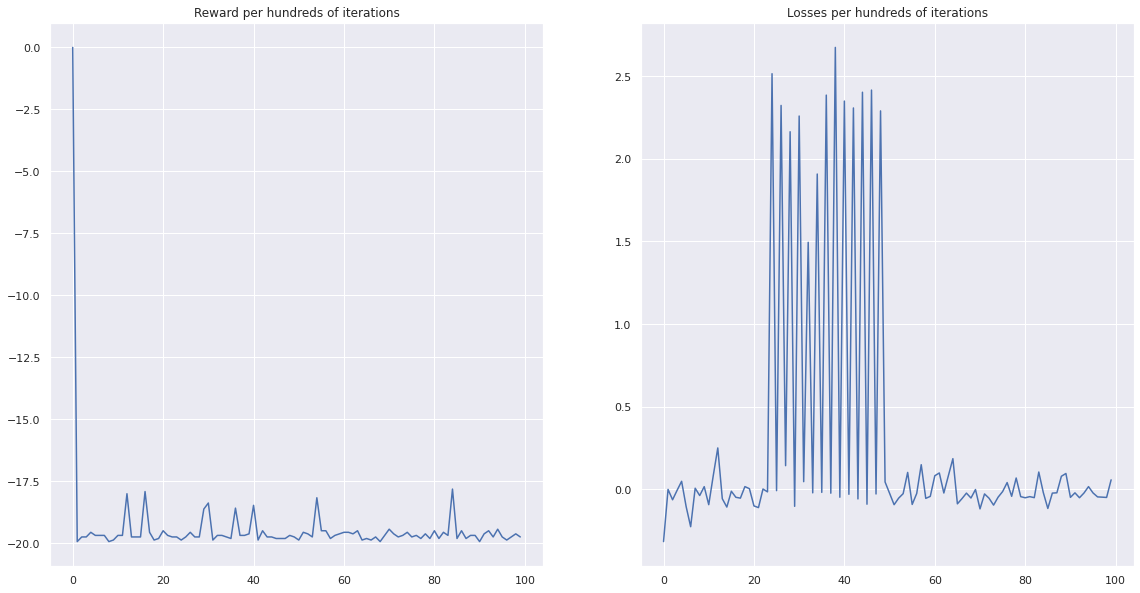

In [ ]:
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.title('Reward per hundreds of iterations')
plt.plot(all_rewards)
plt.subplot(132)
plt.title('Losses per hundreds of iterations')
plt.plot(all_losses)
plt.show()

Load results trained before from my GitHub for plotting. 

In [6]:
!wget https://raw.githubusercontent.com/kai-wren/DRL_Final_Project/main/Sokoban_A2C_10k_v2/all_losses.txt
!wget https://raw.githubusercontent.com/kai-wren/DRL_Final_Project/main/Sokoban_A2C_10k_v2/all_rewards.txt

--2021-02-03 20:59:04--  https://raw.githubusercontent.com/kai-wren/DRL_Final_Project/main/Sokoban_A2C_10k_v2/all_losses.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 908 [application/octet-stream]
Saving to: ‘all_losses.txt’

all_losses.txt      100%[===================>]     908  --.-KB/s    in 0s      

2021-02-03 20:59:05 (41.3 MB/s) - ‘all_losses.txt’ saved [908/908]

--2021-02-03 20:59:06--  https://raw.githubusercontent.com/kai-wren/DRL_Final_Project/main/Sokoban_A2C_10k_v2/all_rewards.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 O

Importing loaded data into Pandas DataFrame.

In [8]:
import pandas as pd

loaded_rewards = pd.read_pickle(r'/content/all_rewards.txt')
loaded_losses = pd.read_pickle(r'/content/all_losses.txt')

Plot average reward and loss per hundreds of training steps based on saved data.

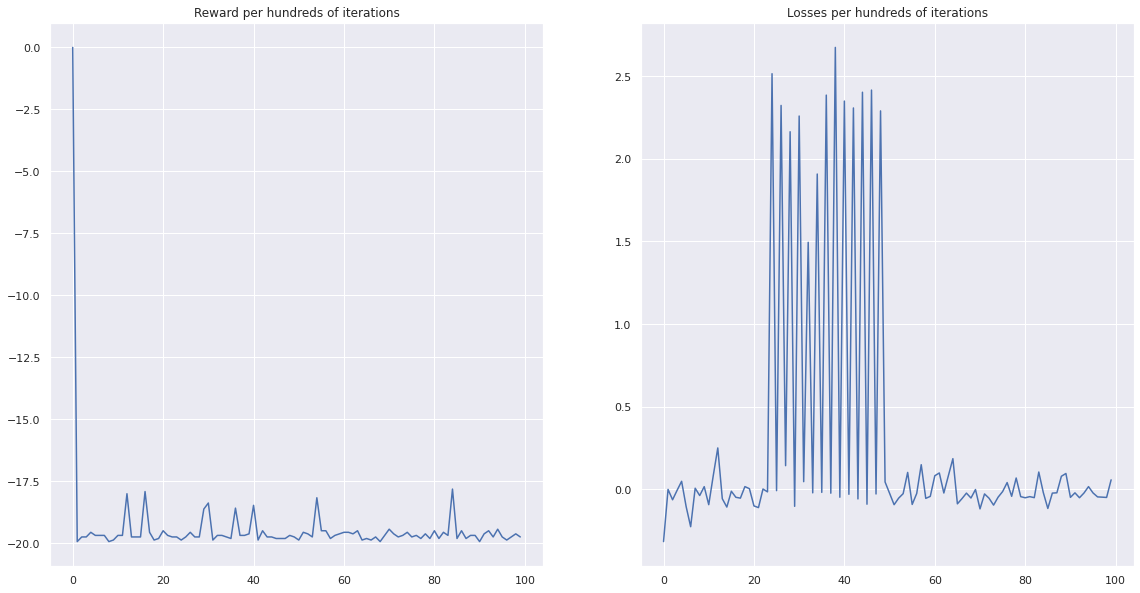

In [9]:
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.title('Reward per hundreds of iterations')
plt.plot(loaded_rewards)
plt.subplot(132)
plt.title('Losses per hundreds of iterations')
plt.plot(loaded_losses)
plt.show()

# Test model

## Trained model

Now testing trained model on Sokoban environment and show its output.

Define reusable method to show agent performance and record a video out of it.

In [15]:
def show_agent_performance(agent, env, n_episodes, max_timesteps):


    env = gym.wrappers.Monitor(env, directory='videos/', force=True)

    for i_episode in range(n_episodes):
        state = env.reset()
        for t in range(max_timesteps):
            env.render()

            state = np.moveaxis(state, -1,0)
            state = torch.FloatTensor(np.float32(state))
            state = state.unsqueeze(0)

            if USE_CUDA:
                state = state.cuda()
            
            action = agent.act(state)
            action = action.squeeze(1).cpu().data.numpy()[0]
            state, reward, done, info = env.step(action)

            if done:
                print("Episode finished after {} timesteps".format(t+1))
                break
        else:
            env.stats_recorder.save_complete()
            env.stats_recorder.done = True

Define reusable method to show agent performance and plot an image on each step.

In [16]:
from IPython.display import clear_output

def show_agent_performance_v2(agent, env, n_episodes, max_timesteps):


    env = gym.wrappers.Monitor(env, directory='videos/', force=True)

    for i_episode in range(n_episodes):
        state = env.reset()
        total_reward = 0
        for t in range(max_timesteps):
            # env.render()

            state = np.moveaxis(state, -1,0)
            state = torch.FloatTensor(np.float32(state))
            state = state.unsqueeze(0)

            if USE_CUDA:
                state = state.cuda()
            
            action = agent.act(state)
            action = action.squeeze(1).cpu().data.numpy()[0]
            state, reward, done, info = env.step(action)

            total_reward += reward
            clear_output(True)
            plt.title("step %i"%t)
            plt.imshow(env.render('rgb_array'))
            plt.show()

            if done:
                print("Episode finished after {} timesteps".format(t+1))
                print("Final reward %.5f" %total_reward)
                break

Reseting seaborn style to have better images of game environment.

In [31]:
sns.reset_defaults()

Creating an environment and A2C agent for testing.

In [ ]:
env = gym.make('Sokoban-v0')

state_shape = env.observation_space.shape
state_shape = (state_shape[2], state_shape[0], state_shape[1])
num_actions = env.action_space.n

actor_critic = ActorCritic(state_shape, num_actions)

actor_critic.load_state_dict(torch.load("/content/Data/actor_critic"))

USE_CUDA = torch.cuda.is_available()

if USE_CUDA:
  actor_critic.cuda()

Test model and record a video out of it.

In [ ]:
pyvirtualdisplay.Display(visible=False, size=(140, 100)).start()
d_env = gym.make('Sokoban-v0')
show_agent_performance(actor_critic, d_env, 5, 300)

Episode finished after 200 timesteps
Episode finished after 200 timesteps
Episode finished after 200 timesteps
Episode finished after 200 timesteps
Episode finished after 200 timesteps


Play recorded video in the notebook itself.

In [ ]:
import kora
from IPython.display import HTML
from kora.drive import upload_public

def play_video(name):
  url = upload_public(f'videos/{name}')
  return HTML(f"""<video src={url} width=500 controls/>""")

play_video('openaigym.video.2.529.video000000.mp4') #change of file name might be required for each run

Test model and plot a picture on each step.

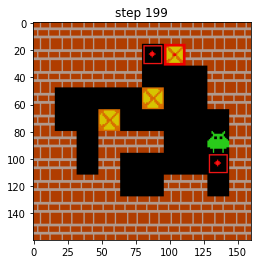

Episode finished after 200 timesteps
Final reward -19.00000


In [ ]:
pyvirtualdisplay.Display(visible=False, size=(140, 100)).start()
d_env = gym.make('Sokoban-v0')
show_agent_performance_v2(actor_critic, d_env, 1, 300)

## Saved model

Download model trained by me from GitHub if training need to be skipped.

In [10]:
!wget https://raw.githubusercontent.com/kai-wren/DRL_Final_Project/main/Sokoban_A2C_10k_v2/actor_critic

--2021-02-03 21:20:55--  https://raw.githubusercontent.com/kai-wren/DRL_Final_Project/main/Sokoban_A2C_10k_v2/actor_critic
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33885011 (32M) [application/octet-stream]
Saving to: ‘actor_critic’

actor_critic        100%[===================>]  32.31M   159MB/s    in 0.2s    

2021-02-03 21:20:57 (159 MB/s) - ‘actor_critic’ saved [33885011/33885011]



Creating an environment and load A2C agent for testing.

In [13]:
env = gym.make('Sokoban-v0')

state_shape = env.observation_space.shape
state_shape = (state_shape[2], state_shape[0], state_shape[1])
num_actions = env.action_space.n

actor_critic_loaded = ActorCritic(state_shape, num_actions)

actor_critic_loaded.load_state_dict(torch.load("/content/actor_critic"))

USE_CUDA = torch.cuda.is_available()

if USE_CUDA:
  actor_critic_loaded.cuda()

Test model and record a video out of it.

In [26]:
pyvirtualdisplay.Display(visible=False, size=(140, 100)).start()
d_env = gym.make('Sokoban-v0')
show_agent_performance(actor_critic_loaded, d_env, 5, 300)

Episode finished after 200 timesteps
Episode finished after 200 timesteps
Episode finished after 200 timesteps
Episode finished after 200 timesteps
Episode finished after 200 timesteps


Play recorded video in the notebook itself.

In [29]:
import kora
from IPython.display import HTML
from kora.drive import upload_public

def play_video(name):
  url = upload_public(f'videos/{name}')
  return HTML(f"""<video src={url} width=500 controls/>""")

play_video('openaigym.video.3.76.video000001.mp4') #change of file name might be required for each run

Test model and plot a picture on each step.

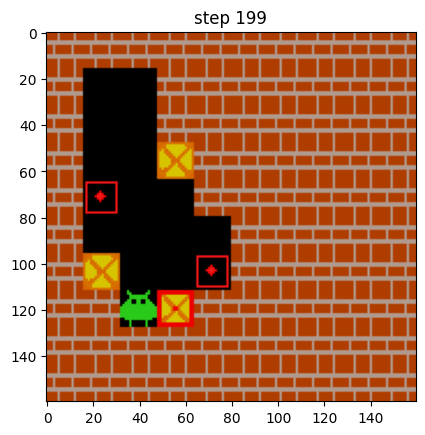

Episode finished after 200 timesteps
Final reward -19.00000


In [32]:
pyvirtualdisplay.Display(visible=False, size=(140, 100)).start()
d_env = gym.make('Sokoban-v0')
show_agent_performance_v2(actor_critic_loaded, d_env, 1, 300)